In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import wandb
import math
import argparse
import datetime
from time import time

In [2]:
################ generate data ###############

# generating Gaussian measure on torus; diagonizable in Fourier

def generate_matern_laplace1d(num_samples, grid_size, sigma_sq=1.0, length_scale=1.0, s=2.0, seed=None):
    """
    Generate Matérn GP using the operator form σ²(-Δ + l²I)^{-s}
    
    Args:
        grid_size (int): Size of the grid (N x N)
        sigma_sq (float): Variance parameter σ²
        length_scale (float): Length scale l
        s (float): Smoothness parameter s
        seed (int): Random seed for reproducibility
    
    Returns:
        torch.Tensor: Sample from the GP
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate frequency grid (scaled by 2π)
    freq = torch.fft.fftfreq(grid_size) * 2 * math.pi * grid_size
    
    # Compute -Laplacian in Fourier space: |k|²
    laplacian = freq**2
    
    # Compute spectral density: σ²(|k|² + l²)^{-s}
    spectral_density = sigma_sq * (laplacian + length_scale**2)**(-s)
    spectral_density = spectral_density.unsqueeze(0)  # adding 1 dim
    
    # Generate complex Gaussian noise
    noise_real = torch.randn(num_samples, grid_size)
    noise_imag = torch.randn(num_samples, grid_size)
    noise = noise_real + 1j * noise_imag
    
    # Apply sqrt of spectral density
    spectral_sample = torch.sqrt(spectral_density) * noise
    
    # Transform back to spatial domain
    sample = torch.fft.ifft(spectral_sample, norm='forward')
    sample = sample.real
    
    return sample[:,None,...]

# Example usage

# grid_size = 64

# sample = generate_matern_laplace1d(
#     num_samples=1000,
#     grid_size=grid_size,
#     sigma_sq=1,
#     length_scale=1.0,
#     s=3,
#     seed=42
# )



In [3]:
################ data loader ################

def get_AllenCahn_dataloader(grid_size, batch_size, train_test_split, subsampling_ratio = None, loc="./data/"):
    """
    get dataloader for 2D Allen Cahn

    Parameters
    ----------
    grid_size: resolutions of the field
    batch_size: batch size
    train_test_split: a ratio representing the splitting of training/testing data
    subsampling_ratio: used for subsampling a small portion of data, for convenient small scale experiments
    """
    loc = loc + f"AllenCahn1D_grid{grid_size}_samples.npy"
    
    data_raw = np.load(loc)
    print(f"[Data] raw data shape is {data_raw.shape}")
    torch_data = torch.from_numpy(data_raw)
    torch_data = torch.reshape(torch_data, (-1,torch_data.shape[-1]))
    print(f"[Data] flattened torchdata, shape is {torch_data.shape}")
    norm_per_pixel = torch.norm(torch_data,dim=(1),p='fro').mean()/torch_data.shape[-1]
    print(f"[Data] norm per pixel {norm_per_pixel}")

    if subsampling_ratio:
        torch_data = torch_data[:int(subsampling_ratio*torch_data.size()[0]),...]

    num_train = int(torch_data.size()[0]*train_test_split)
    print(f'---- [processing] train_test_split {train_test_split}, num of training {num_train}, testing {torch_data.size()[0]-num_train}')
    
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch_data[:num_train,None,:grid_size].float()), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch_data[num_train:,None,:grid_size].float()), batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, norm_per_pixel


In [4]:
# grid_size = 64
# batch_size = 1000
# train_test_split = 0.9

# train_loader, test_loader, norm_per_pixel = get_AllenCahn_dataloader(grid_size, batch_size, train_test_split, subsampling_ratio = None)

In [5]:
################ network ################

from unet1D import Unet1D
class Velocity(nn.Module):
    """ 
    This is a wrapper around any architecture
    The warpper handles the additional conditioning input by appending conditioning input as a channel
    """
    def __init__(self, config):
        super(Velocity, self).__init__()
        self.config = config
        self._arch = Unet1D(
            config.unet_channels,
            dim_mults=config.unet_dim_mults,
            channels = config.C + config.cond_channels,
            out_dim = config.C,
            learned_sinusoidal_cond = config.unet_learned_sinusoidal_cond,
            random_fourier_features = config.unet_random_fourier_features,
        )
        num_params = np.sum([int(np.prod(p.shape)) for p in self._arch.parameters()])
        print("[Network] Num params in main arch for velocity is", f"{num_params:,}")

    def forward(self, zt, t, cond=None):
        inputs = zt
        if cond is not None:
            """appending conditioning input as a channel""" 
            inputs = torch.cat([inputs, cond], dim=1)
        out = self._arch(inputs, t)
        return out

In [6]:
################ interpolants and sampler ################

class Interpolants:
    
    """ 
    Definition of interpolants
    I_t = alpha x_0 + beta x_1 (x_0 is Gaussian base)
    R_t = alpha_dot x_0 + beta_dot x_1
    """
    
    def __init__(self, config):
        super(Interpolants, self).__init__()
        self.config = config
        
    def alpha(self, t):
        return 1-t

    def alpha_dot(self, t):
        return -1.0 * torch.ones_like(t)

    def beta(self, t):
        return t

    def beta_dot(self, t):
        return 1.0 * torch.ones_like(t)
    
    def wide(self, x):
        return x[:, None, None]

    def It(self, D):
        """
        D is a dictionary containing 
        x0 = z0, 
        x1 = z1, 
        zt = I_t = alpha x_0 + beta x_1
        """
        z0 = D['z0']
        z1 = D['z1']
        t = D['t']

        aterm = self.wide(self.alpha(t)) * z0
        bterm = self.wide(self.beta(t)) * z1

        D['zt'] = aterm + bterm
        return D

    def Rt(self, D):
        """
        D is a dictionary containing 
        x0 = z0, 
        x1 = z1, 
        R_t = alpha_dot x_0 + beta_dot x_1
        """
        z0 = D['z0']
        z1 = D['z1']
        t = D['t']

        adot = self.wide(self.alpha_dot(t))
        bdot = self.wide(self.beta_dot(t))
        return (adot * z0) + (bdot * z1)


class Sampler:
    """
    sampler 
    self.interpolant: get information from the defined interpolants
    self.logger: information for uploading results to wandb, used in self.log_wandb_figure
    self.EM: EM for sampling
    """
    def __init__(self, config):
        self.config = config
        self.logger = Loggers(config)
        self.interpolant = Interpolants(config)
        return
    
    def wide(self, x):
        return x[:, None, None, None]

    def EM(self, D, model, steps = 200):  # here it is EM, for improved performance, should use odeint
        print('[Sampler] Use EM samplers')
        init_condition = D['z0']
        tgrid = torch.linspace(self.config.t_min_sample, self.config.t_max_sample, steps).type_as(init_condition)
        dt = tgrid[1] - tgrid[0]
        zt = D['z0']
        cond = D['cond']
        ones = torch.ones(zt.shape[0]).type_as(zt)
        for tscalar in tgrid:
            t_arr = tscalar * ones
            f = model(zt, t_arr, cond = cond) # note we condiition on init cond
            zt_mean = zt + f * dt
            zt = zt_mean
        return zt_mean

    @torch.no_grad()
    def sample(self, D, model, global_step):
        model.eval()
        zT = self.EM(D, model)     


In [7]:
import scipy.stats as stats
def get_energy_spectrum1d(vorticity_trajectory):
    vorticity_hat = torch.fft.fft(vorticity_trajectory,dim=(1),norm = "forward")
    fourier_amplitudes = np.abs(vorticity_hat)**2 
    fourier_amplitudes = fourier_amplitudes.mean(dim=0)
    npix = vorticity_hat.shape[-1]
    kfreq = np.fft.fftfreq(npix) * npix
    knrm = np.sqrt(kfreq**2)
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    
    kvals = knrm
    Abins_w = fourier_amplitudes
    
    return kvals, Abins_w

def plot_spectra(trajectory_1,trajectory_2, save_name = './energy_spectrum.jpg'):
    
    kvals, Abins_w1 = get_energy_spectrum1d(trajectory_1)
    kvals, Abins_w2 = get_energy_spectrum1d(trajectory_2)
    
    fig = plt.figure(figsize=(5,5))
    plt.plot(kvals, Abins_w1, label = 'spectrum of truth')
    plt.plot(kvals, Abins_w2, '--', label = 'spectrum of generated')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig(save_name,dpi=300, bbox_inches='tight', transparent=True,facecolor='w')
    return


In [8]:
################ trainer ################

class Trainer:
    """
    Trainer
    self.time_dist: used for sampling time during training
    """
    def __init__(self, config):
        super(Trainer, self).__init__()
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.interpolant = Interpolants(self.config)
        self.model = Velocity(self.config)
        self.model.to(self.device)
        self.optimizer = self.get_optimizer(config)
        self.sampler = Sampler(config)
        self.time_dist = torch.distributions.Uniform(low=self.config.t_min_train, high=self.config.t_max_train)
        self.global_step = 0
        self.EMsteps = config.EMsteps
        self.home = config.home
        self.prepare_dataset(subsampling_ratio = config.data_subsampling_ratio)
        print(f'[save_loc] will save all checkpoints and results to location to {self.home}')

    def prepare_dataset(self, subsampling_ratio = None):
        self.train_loader, self.test_loader, self.avg_pixel_norm = get_AllenCahn_dataloader(self.config.grid_size, self.config.batch_size, self.config.train_test_split, subsampling_ratio = subsampling_ratio)
        self.config.avg_pixel_norm = self.avg_pixel_norm

    
    @torch.no_grad()
    def prepare_batch(self, batch, time = 'unif'):
        """
        D: a dictionary of x0, x1, and t, for interpolants
        here x0 = noise
             x1 = data
             t = uniform samples from [0,1]
        """
        target = batch[0]
        target = target.to(self.device)

        noise = generate_matern_laplace1d(self.config.batch_size, self.config.dim, sigma_sq=self.config.sigma_sq0, length_scale=self.config.length_scale0, s=self.config.s0)
        
        noise = noise.to(self.device)
        D = {'z0': noise, 'z1': target, 'cond': None}
        
        if time == 'unif':
            D['t'] = self.time_dist.sample(sample_shape = (target.shape[0],)).squeeze().type_as(D['z1'])
        else:
            assert False
        D = self.interpolant.It(D)
        return D
    
    def get_optimizer(self, config):
        if config.optimizer == "AdamW":
            print(f'[Optimizer] set up optimizer as {config.optimizer}')
            self.lr = self.config.base_lr
            return torch.optim.AdamW(self.model.parameters(), lr=self.config.base_lr)
    
    def target_function(self, D):
        target = self.interpolant.Rt(D)  
        return target
    
    def loss_function(self, D):
        assert self.model.training
        model_out = self.model(D['zt'], D['t'], cond = D['cond'])
        target = self.target_function(D)
        loss = (model_out - target).pow(2).sum(-1).sum(-1).sum(-1) # using full squared loss here
        return loss.mean()
    
    def clip_grad_norm(self, model, max_grad_norm = 1e+5):
        return torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = max_grad_norm, norm_type = 2.0, error_if_nonfinite = False)

    def optimizer_one_step(self, max_grad_norm = 1e+5):
        self.clip_grad_norm(self.model, max_grad_norm = max_grad_norm)
        if self.global_step % self.config.print_loss_every == 0:
            grads = [ param.grad.detach().flatten() for param in self.model.parameters() if param.grad is not None]
            norm = torch.cat(grads).norm()
            print(f"[Training] Grad step {self.global_step}. Grad norm:{norm}")
            if self.config.use_wandb:
                wandb.log({"Gradnorm": norm}, step = self.global_step)
        self.optimizer.step()
        self.optimizer.zero_grad(set_to_none=True)
        self.global_step += 1
    
    def adjust_learning_rate(self, optimizer):
        lr = self.lr
        if self.config.cosine_scheduler:
            scale = self.global_step / self.config.max_steps
            lr *= 0.5 * (1. + math.cos(math.pi * scale))
            print(f'[Cosine scheduler] lr is now {lr}')
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    
    def fit(self,):
        time_begin = time()
        print("[Training] starting training")
        self.test_model(first_batch_only = True)
        
        while True:
            
            if self.global_step >= self.config.max_steps:
                break
                
            for batch in self.train_loader:
                if self.global_step % 100 == 0:
                    print(f"[Training] starting step {self.global_step}")
                if self.global_step >= self.config.max_steps:
                    break
        
                self.model.train()
                loss = self.loss_function(D = self.prepare_batch(batch))
                loss.backward()
                self.optimizer_one_step()     
    
                if self.global_step % self.config.print_loss_every == 0:
                    total_mins = (time() - time_begin) / 60
                    print(f"[Training] Grad step {self.global_step}. Loss:{loss.item()}, finished in {total_mins:.2f} minutes")
                    if self.config.use_wandb:
                        wandb.log({"loss": loss.item()}, step=self.global_step)
                
                if self.global_step % self.config.save_model_every == 0:
                    self.save_model_checkpoint()
                if self.global_step % self.config.test_every == 0:
                    self.test_model(first_batch_only = True)
    
                if self.global_step % 100 == 0:
                    self.adjust_learning_rate(self.optimizer)
    
    #### below are testing functions, during the training processes or after training
    def save_model_checkpoint(self):
        
        if not os.path.exists(self.home + f"checkpoint/{logger.verbose_log_name}"):
            os.makedirs(self.home + f"checkpoint/{logger.verbose_log_name}")
        save_path = self.home + f"checkpoint/{logger.verbose_log_name}/model_step{self.global_step}.pth"
        torch.save(self.model.state_dict(), save_path)
        print(f'[Saving models] saving models to {save_path}')


    def sample_results(self, first_batch_only = True, EMsteps = 200):

        test_truth = torch.zeros(self.config.batch_size,1,self.config.dim)
        test_input = torch.zeros_like(test_truth)
        test_result = torch.zeros_like(test_truth)

        
        self.model.eval()
        time_begin = time()


        for batch_idx, batch in enumerate(self.test_loader):
            if first_batch_only and batch_idx > 0: break
            with torch.no_grad():
                D = self.prepare_batch(batch)
                test_input = D['z0']
                test_truth = D['z1']
                test_result = self.sampler.EM(D, self.model, steps = EMsteps)
                total_mins = (time() - time_begin) / 60
                print(f'finished in {total_mins:.2f} minutes')
            

        results = torch.cat([test_input, test_truth, test_result], dim = 1)
        return results
    
    def plot_spectra(self, results):

        # energy spectrum
        if not os.path.exists(self.home + "images"):
            os.makedirs(self.home + "images")
        
        spectrum_save_name = self.home + f"images/{logger.verbose_log_name}_spectrum_test.jpg"
        plot_spectra(results[:,1,...].cpu(), results[:,2,...].cpu(), save_name = spectrum_save_name)
        print(f"spectrum plot saved to {spectrum_save_name}")
        
        tensor_img = T.ToTensor()(Image.open(spectrum_save_name))

        f = lambda x: wandb.Image(x[None,...])
        if config.use_wandb:
            wandb.log({f'energy spectrum (test )': f(tensor_img)}, step = self.global_step) 
    
    def compute_norm(self, results):
        truth = results[:,1,...]
        forecast = results[:,2,...]
        truth_norm = torch.norm(truth,dim=(1),p='fro').mean() / np.sqrt(self.config.dim)
        forecast_norm = torch.norm(forecast,dim=(1),p='fro').mean() / np.sqrt(self.config.dim)
        relerr = abs(truth_norm-forecast_norm)/truth_norm
        print(f"[testing norms] truth norm is {truth_norm}, forecast norm is {forecast_norm}, relative err {relerr}")
        if self.config.use_wandb:
            wandb.log({f"norm err":  relerr}, step = self.global_step)
    
    def test_model(self, first_batch_only = True):
        
        test_results = self.sample_results(first_batch_only = first_batch_only, EMsteps = self.EMsteps)

        # norm test
        self.compute_norm(test_results)
        
        # spectrum test
        self.plot_spectra(test_results)       

            

In [9]:
################ logger ################

class Loggers:
    """
    self.log_base: date string for naming of logging files
    self.log_name: detailed information of the experiment, used for naming of logging files
    self.verbose_log_name: more verbose version for naming
    """
    def __init__(self, config):
        date = str(datetime.datetime.now())
        self.log_base = date[date.find("-"):date.rfind(".")].replace("-", "").replace(":", "").replace(" ", "_")
        self.log_name =  'grid_size' + str(config.grid_size) + '_' + self.log_base
        self.verbose_log_name = 'GaussODE_AllenCahntarget' + '_grid_size' + str(config.grid_size) + 'sz' + str(config.base_lr).replace(".","") + 'max' + str(config.max_steps) + '_' + self.log_base
        
    def is_type_for_logging(self, x):
        if isinstance(x, int):
            return True
        elif isinstance(x, float):
            return True
        elif isinstance(x, bool):
            return True
        elif isinstance(x, str):
            return True
        elif isinstance(x, list):
            return True
        elif isinstance(x, set):
            return True
        else:
            return False

    def setup_wandb(self, config):
        if config.use_wandb:
            config.wandb_run = wandb.init(
                    project=config.wandb_project,
                    entity=config.wandb_entity,
                    resume=None,
                    id    =None,
                    name = self.verbose_log_name,
            )
            wandb.run.log_code(".")

            for key in vars(config):
                item = getattr(config, key)
                if self.is_type_for_logging(item):
                    setattr(wandb.config, key, item)
                    print(f'[Config] {key}: {item}')
            print("[wandb] finished wandb setup")
        else:
            print("[wandb] not using wandb setup")

In [66]:
################ config ################


class Config:
    def __init__(self, home = "./"):
        
        # use wandb for logging
        self.use_wandb = False
        self.wandb_project = 'interpolants_forecasting_new'
        self.wandb_entity = 'yifanc96'

        self.home = home # for storing checkpoints
        
        # data
        self.seed = 42
        self.C = 1
        self.grid_size = 64
        self.dim = self.grid_size
        self.batch_size = 1000
        self.train_test_split = 0.9
        self.data_subsampling_ratio = 1.0  # use a small amount of data, for sanity check of the code

        ## spectrum noise set-up
        self.s0 = 1
        self.length_scale0 = 1
        self.sigma_sq0 = 10
        
        # training
        self.optimizer = 'AdamW'
        self.cosine_scheduler = True
        self.base_lr = 2*1e-4
        self.max_steps = 100
        self.t_min_train = 1e-4
        self.t_max_train = 1 - 1e-4
        self.t_min_sample = 0
        self.t_max_sample = 1
        self.EMsteps = 200
        self.print_loss_every = 10 
        self.print_gradnorm_every =  10

        self.test_every = 500 # test energy spectrum and norm on reference batch every # iterations
        self.save_model_every = 2000 # save model checkpoints every # iterations
        
        # architecture
        self.unet_use_classes = False
        self.model_size = 'medium'
        if self.model_size == 'small':
            self.unet_channels = 8
            self.unet_dim_mults = (1, 1, 1, 1)
            self.unet_resnet_block_groups = 8
            self.unet_learned_sinusoidal_dim = 8
            self.unet_attn_dim_head = 8
            self.unet_attn_heads = 1
            self.unet_learned_sinusoidal_cond = False
            self.unet_random_fourier_features = False
        
        elif self.model_size == 'medium':
            self.unet_channels = 32
            self.unet_dim_mults = (1, 2, 2, 2)
            self.unet_resnet_block_groups = 8
            self.unet_learned_sinusoidal_dim = 32
            self.unet_attn_dim_head = 32
            self.unet_attn_heads = 4
            self.unet_learned_sinusoidal_cond = True
            self.unet_random_fourier_features = False
   
        elif self.model_size == 'large':
            self.unet_channels = 128
            self.unet_dim_mults = (1, 2, 2, 2)
            self.unet_resnet_block_groups = 8
            self.unet_learned_sinusoidal_dim = 32
            self.unet_attn_dim_head = 64
            self.unet_attn_heads = 4
            self.unet_learned_sinusoidal_cond = True
            self.unet_random_fourier_features = False
        else:
            assert False
        self.cond_channels = 0 # no conditioning
        # the conditioned term is appended to the input (so the final channel dim = cond_channels + input_channels)


In [170]:
def get_parser():
    parser = argparse.ArgumentParser(description='PyTorch framework for stochastic interpolants')
    parser.add_argument("--data_subsampling_ratio", type=float, default=1.0)
    parser.add_argument("--batch_size", type=int, default=5000)
    parser.add_argument("--base_lr", type=float, default=2e-4)
    parser.add_argument("--grid_size", type=int, default=32)
    parser.add_argument("--dim", type=int, default=32)
    parser.add_argument("--max_steps", type=int, default=50000)
    parser.add_argument("--sample_every", type=int, default=1000)
    parser.add_argument("--test_every", type=int, default=1000)
    parser.add_argument("--save_model_every", type=int, default=2000)
    parser.add_argument("--num_dataset",type=int,default=1)
    parser.add_argument('--use_wandb', type = int, default = 0) # 1 is use_wandb, and 0 is not use_wandb
    args = parser.parse_args(args=[])
    return args

random_seed = 0
torch.manual_seed(0)
np.random.seed(random_seed)
args = get_parser()
args.use_wandb = bool(args.use_wandb)


##### checkpoint and image storage location
home = "/scratch/yc3400/forecasting/" 

config = Config(home)
for arg in vars(args):
    print(f'[Argparse] change config {arg} to {getattr(args, arg)}')
    setattr(config, arg, getattr(args, arg))
logger = Loggers(config)
logger.setup_wandb(config)
trainer = Trainer(config)
# trainer.fit()

[Argparse] change config data_subsampling_ratio to 1.0
[Argparse] change config batch_size to 5000
[Argparse] change config base_lr to 0.0002
[Argparse] change config grid_size to 32
[Argparse] change config dim to 32
[Argparse] change config max_steps to 50000
[Argparse] change config sample_every to 1000
[Argparse] change config test_every to 1000
[Argparse] change config save_model_every to 2000
[Argparse] change config num_dataset to 1
[Argparse] change config use_wandb to False
[wandb] not using wandb setup
[Network] Num params in main arch for velocity is 1,061,577
[Optimizer] set up optimizer as AdamW
[Data] raw data shape is (66, 100000, 33)
[Data] flattened torchdata, shape is torch.Size([6600000, 33])
[Data] norm per pixel 0.1480783240882781
---- [processing] train_test_split 0.9, num of training 5940000, testing 660000
[save_loc] will save all checkpoints and results to location to /scratch/yc3400/forecasting/


In [171]:
##### inference

checkpoint_folder = "./checkpoints/"
# ## dim128-spectrum noise
PATH_file = checkpoint_folder + "dim128_spectrum_noise_model_trained50000steps.pth"
# ## dim64-spectrum noise
PATH_file = checkpoint_folder + "dim64_spectrum_noise_model_trained50000steps.pth"
# ## dim32-spectrum noise
PATH_file = checkpoint_folder + "dim32_spectrum_noise_model_trained50000steps.pth"


print(PATH_file)




/scratch/yc3400/forecasting/checkpoint/GaussODE_AllenCahntarget_grid_size32sz00001max50000_0528_162027/model_step50000.pth


In [172]:
res_load = torch.load(PATH_file)
trainer.model.load_state_dict(res_load)
trainer.model.eval()

/state/partition1/job-62386845/ipykernel_2455525/2981232837.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res_load = torch.load(PATH_file)


Velocity(
  (_arch): Unet1D(
    (init_conv): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (time_mlp): Sequential(
      (0): RandomOrLearnedSinusoidalPosEmb()
      (1): Linear(in_features=17, out_features=128, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=128, out_features=128, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=128, out_features=64, bias=True)
          )
          (block1): Block(
            (proj): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (block2): Block(
            (proj): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
            (norm): RMSNorm()
            (act): SiLU()
            (dropout): Dropout(p=0.0, inplace=Fa

In [173]:
#### inference: EM integration

# EM_steps = 200
# from time import time
# time_begin = time()
# for batch_idx, batch in enumerate(trainer.test_loader):
#     if batch_idx > 0: break
#     with torch.no_grad():
#         D = trainer.prepare_batch(batch)
#         test_input = D['z0']
#         test_truth = D['z1']
#         test_result = trainer.sampler.EM(D, trainer.model, steps = EM_steps)
#         total_mins = (time() - time_begin) / 60
#         print(f'finished in {total_mins:.2f} minutes')
# results = torch.cat([test_input, test_truth, test_result], dim = 1)



In [174]:
### inference: RK integration

from torchdiffeq import odeint
class PFlowRHS(nn.Module):
    def __init__(self, drift_b):
        super(PFlowRHS, self).__init__()
        self.drift_b = drift_b
        
    def forward(self, t, states):
        (zt,) = states
        t_arr = torch.ones(zt.shape[0]).type_as(zt) * t
        dzt = self.drift_b(zt, t_arr)
        return (dzt,)
             
class PFlowIntegrator:
        
    def __init__(self):
        return        

    def __call__(self, drift_b, z0, T_min, T_max, steps, method='dopri5', return_last = True):

        rhs = PFlowRHS(drift_b)

        t = torch.linspace(
            T_min, T_max, steps
        ).type_as(z0)

        int_args = {
            'method': method, 
            # 'atol': c.integration_atol, 
            # 'rtol': c.integration_rtol,
        }

        (z,) = odeint(rhs, (z0,), t, **int_args)
        if return_last:
            return z[-1].clone()
        else:
            return z

pflow = PFlowIntegrator()

t_min_sample = 1e-4
t_max_sample = 1-1e-4
drift_b = trainer.model
time_begin = time()
for batch_idx, batch in enumerate(trainer.test_loader):
    if batch_idx > 0: break
    with torch.no_grad():
        D = trainer.prepare_batch(batch)
        test_input = D['z0']
        test_truth = D['z1']
        test_result = out = pflow(
            drift_b = drift_b,
            z0 = D['z0'],
            T_min = t_min_sample,
            T_max = t_max_sample,
            steps = 10, 
            method = 'rk4',
            return_last = True,)
        total_mins = (time() - time_begin) / 60
        print(f'finished in {total_mins:.2f} minutes')

results = torch.cat([test_input, test_truth, test_result], dim = 1)



finished in 0.04 minutes


/state/partition1/job-62386845/ipykernel_2455525/3056257141.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fourier_amplitudes = np.abs(vorticity_hat)**2


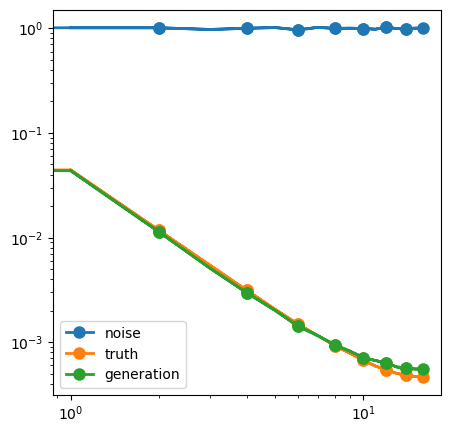

In [175]:
kvals, Abins_w0 = get_energy_spectrum1d(results[:,0,...].cpu())
kvals, Abins_w1 = get_energy_spectrum1d(results[:,1,...].cpu())
kvals, Abins_w2 = get_energy_spectrum1d(results[:,2,...].cpu())

fig = plt.figure(figsize=(5,5))
plt.plot(kvals, Abins_w0, linewidth=2, marker='o', markersize=8, markevery=2, label = 'noise')
plt.plot(kvals, Abins_w1, linewidth=2, marker='o', markersize=8, markevery=2, label = 'truth')
plt.plot(kvals, Abins_w2, linewidth=2, marker='o', markersize=8, markevery=2, label = 'generation')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [176]:
# torch.save(Abins_w2, "AllenCahn-res32-standard-schedule-RK10.pt")
# torch.save(kvals, "AllenCahn-res32-kvals.pt")
# torch.save(Abins_w1, "AllenCahn-res32-truth.pt")


In [149]:
#### test: interpolation schedule
ratio = 4*10**(-5)

print(ratio)

# scalar interpolant
def alpha(t):
    return torch.sqrt((ratio - ratio**t)/(ratio - 1)) * torch.ones_like(t)

def alpha_dot(t):
    return -0.5*1/alpha(t)*(ratio**t)*math.log(ratio)/(ratio - 1) 
    
def beta(t):
    return torch.sqrt((ratio**t - 1)/(ratio - 1)) * torch.ones_like(t)

def beta_dot(t):
    return 0.5*1/beta(t)*(ratio**t)*math.log(ratio)/(ratio - 1)




4e-05


In [150]:
def new_drift_bt(zt, t, cond = None):
    bt = (alpha_dot(t)/alpha(t))[:,None,None]*zt
    coef = beta_dot(t) - alpha_dot(t)*beta(t)/alpha(t)
    coef = coef[:,None,None]
    orig_t = 1/(1+alpha(t)/beta(t))
    orig_x = orig_t[:,None,None]/(beta(t)[:,None,None])*zt
    orig_bt = trainer.model(orig_x, orig_t, cond = cond) 
    bt += coef*((1-orig_t[:,None,None])*orig_bt + orig_x)
    return bt

drift_b = new_drift_bt
time_begin = time()
for batch_idx, batch in enumerate(trainer.test_loader):
    if batch_idx > 0: break
    with torch.no_grad():
        D = trainer.prepare_batch(batch)
        test_input = D['z0']
        test_truth = D['z1']
        test_result = out = pflow(
            drift_b = drift_b,
            z0 = D['z0'],
            T_min = t_min_sample,
            T_max = t_max_sample,
            steps = 10, 
            method = 'rk4',
            return_last = True,)
        total_mins = (time() - time_begin) / 60
        print(f'finished in {total_mins:.2f} minutes')

results = torch.cat([test_input, test_truth, test_result], dim = 1)

finished in 0.12 minutes


/state/partition1/job-62386845/ipykernel_2455525/3056257141.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  fourier_amplitudes = np.abs(vorticity_hat)**2


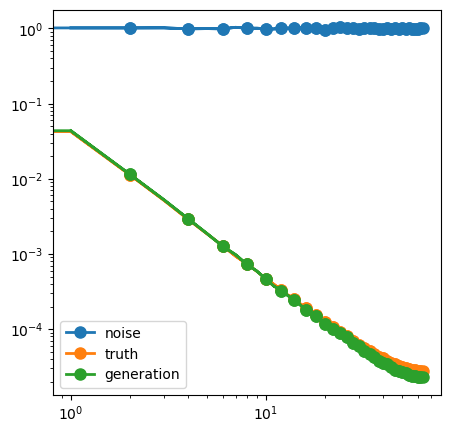

In [151]:
kvals, Abins_w0 = get_energy_spectrum1d(results[:,0,...].cpu())
kvals, Abins_w1 = get_energy_spectrum1d(results[:,1,...].cpu())
kvals, Abins_w2 = get_energy_spectrum1d(results[:,2,...].cpu())

fig = plt.figure(figsize=(5,5))
plt.plot(kvals, Abins_w0, linewidth=2, marker='o', markersize=8, markevery=2, label = 'noise')
plt.plot(kvals, Abins_w1, linewidth=2, marker='o', markersize=8, markevery=2, label = 'truth')
plt.plot(kvals, Abins_w2, linewidth=2, marker='o', markersize=8, markevery=2, label = 'generation')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [105]:
# torch.save(Abins_w2, "AllenCahn-res32-scaled-schedule-RK10.pt")